# Titanic: Machine Learning from Disaster

https://www.kaggle.com/c/titanic

https://www.kaggle.com/startupsci/titanic-data-science-solutions/notebook

## 問題の特定

タイタニック号の沈没は、歴史上最も忌まわしい海難事故の一つである。1912年4月15日、タイタニックは処女航海中に氷山に衝突し沈没した。乗客/乗員2224人のうち1502人が亡くなった。

本プロジェクトは、機械学習を利用し、この海難事故で、どのような人々が生き残ったのかを分析することである。そのために、事故で生き残った人とそうでなかった人の情報をもとにモデルを構築し、与えられたテストデータを使い、その乗客が生き残ったかどうかを予測する。

In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# ignore warinings
import warnings
warnings.filterwarnings('ignore')

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

## データの取得

In [2]:
train_df = pd.read_csv('../input/train.csv')
test_df = pd.read_csv('../input/test.csv')
combine = [train_df, test_df]

### どのような特徴量が利用可能か？

In [3]:
print(train_df.columns.values)

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']


- PassengerId : 乗客ID
- Survived : 生き残ったかどうか
- Pclass : 旅行の等級 (1等, 2等, 3等）
- Name : 乗客の氏名
- Sex : 性別
- Age : 年齢
- SibSp : 同乗している兄弟/姉妹や配偶者の数
- Parch : 同乗している親/子供の数
- Ticket : チケット
- Fare : 運賃
- Cabin : 船室
- Embarked : 乗客が乗船した港（C - Cherbourg, S - Southhampton, Q - Queenstown）

In [4]:
# preview the data
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### どの特徴量がカテゴリーデータか？

- Categorical
 - Survived
 - Sex
 - Embarked
- Ordinal
 - Pclass


### どの特徴量が数値データか？

- Continous
 - Age
 - Fare
- Discrete
 - SibSp
 - Parch

### どの特徴量が複合データか？

- Ticketは、数値と英数字が混在している。
- Cabinは、英数字である。

### どの特徴量にエラーや誤植が含まれている可能性があるか？

- Nameは、敬称や丸括弧、代替名や略称に使用される引用符など、いくつかの記載方法があるためエラーや誤字が含まれる可能性が考えられる。

### どの特徴量に欠損値が含まれているか？

空白やnullやNaNは、欠損値と呼ばれ、データが欠けていることを表す。このままだと予測精度に影響するので、何らかの形で訂正する必要がある。

- 訓練データで、Cabin, Age, Embarked に欠損値がある。
- テストデータで、Cabin, Age, Fare に欠損値がある。

In [5]:
print('Train columns with null values:\n', train_df.isnull().sum())
print("-" * 40)
print(train_df.info())
print("-" * 40)

print('Test/Validation columns with null values:\n', test_df.isnull().sum())
print("-" * 40)
print(test_df.info())

Train columns with null values:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None
----------------------------------------
Test/Validation columns with null values:
 PassengerId

### 数値特徴量のデータ分布は、どのようになっているのか？

In [6]:
# 数値データに対して各種統計量を計算
# count: 要素数, mean: 算術平均, std: 標準偏差, min: 最小値, 50%: 中央値, max: 最大値
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


- 訓練データの合計は、891。（タイタニック号に搭乗した乗客の実際の数(2224人)の40%を表している）
- Survivied は、0または1の値をもつカテゴリカル特徴量。
- 訓練データの約38%が生き残った。(問題の特定に記載されているように、乗客が2224人で1502人が亡くなり約32%が生き残ったという実データを表せている)
- ほとんどの乗客 (> 75%) は、親または子供と一緒に旅行しなかった。
- 乗客のほぼ30%が兄弟姉妹や配偶者を乗せていた。
- 運賃は、一部の乗客 (< 1%) だけ異常に高く、512ドル払っていた。
- 65歳から80歳までの高齢者はほとんどのっていなかった (< 1%) 。

### カテゴリカル特徴量のデータ分布は、どのようになっているか？

In [7]:
# オブジェクト要素の基本統計量も算出
train_df.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Hippach, Miss. Jean Gertrude",male,CA. 2343,B96 B98,S
freq,1,577,7,4,644


* Nameは、データセット全体で一意。 (count = unique = 891)
* 65%が男性。 (tp = male, freq = 577 / count = 891) (freq: 出現回数)
* 客室の値はいくつかのトレーニングデータで2重になっている。あるいは、複数の状況が客室を共有した。
* Embarkedは、3つの値をとる可能性があるが、ほとんどの乗客がS港から乗船していた。 (top=S)
* Ticket特徴量では、重複した値 (unique = 681)の割合が22%と高い。

## データから考えられる仮説を立てる

**相関関係**

「Survived」を予測したい(0: 亡くなった, 1: 生存した)ので、各特徴量がどのように「Survived」に相関しているかが知りたい。プロジェクトの早い段階でこの作業を行い、プロジェクトの後半でモデル化された相関関係と仮説で考えた相関関係を一致させたい。

**欠損値の補完**

1. Survivedと明らかに相関があるため、Ageの欠損値はなんらかの手段を用いて補完する必要がありそう。
2. Survivedまたは他の重要な特徴量と相関する可能性があるため、Embarkedの欠損値も補完する必要がありそう。

**修正**

1. 重複率(22%)が高く、TicketとSurvivedの間に相関がなさそうなので、Ticket特徴量は分析から除外することになりそう。
2. Cabin特徴量は、訓練データとテストデータの両方で不完全であるか、または多くのnull値を含んでいるため、除外することになりそう。
3. Survivedに寄与したないため、Passengeridは訓練データから除外することになりそう。
4. Nameの特徴量は比較的に非標準な値であり、Survivedの判定に直接貢献しないかもしれない。その場合は除外することになりそう。

**作成**

1. ParchとSibSpに基づいてFamilyという新しい特徴量を作成し、家族の総数を取得したくなるかもしれない。
2. Name特徴量を使用して、Title(敬称)を新しい特徴量として抽出すると良いかもしれない。
3. Age特徴量は、ある程度の幅を表した新しい特徴量としたほうがよいかもしれない。（連続的な数値特徴量を順序尺度のカテゴリカル特徴量に変えることでデータを扱いやすくなるため）
4. 分析に役立つ場合は、Ageと同じようにFareの範囲を特徴量として作成することもできそう。

**予測するのに重要と思われる特徴量**

1. 女性 (性別=女性) は、生存していた可能性が高い。
2. 子供 (年齢 < ?) は、生存していた可能性が高い。
3. 上位クラスの乗客は、生き残った可能性が高い。


## 特徴量の相関を解析する

仮説の一部を確認するために、特徴量のSurvivedとの相関関係を分析する。この段階では、空の値を持たない特徴量に対してのみ分析できる。また、カテゴリ値(Sex), 順序値(Pclass), 離散値(SibSp, Parch)タイプの特徴量に対して分析を行うのが適切である。

- **Pclass** 

 Pclass=1とSurvivedの間に有意な相関(>0.5)が観測された。この特徴量をモデルに含めることにする。


- **性別**

 女性のSurvived率が74%で非常に高いという仮説が正しいことが確認できた。


- **SlibSpとParch**

 これらの特徴は、特定の値では相関がない。これら個々の特徴量から新たな特徴量を作ることが最善策かもしれない。

In [8]:
train_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [9]:
train_df[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [10]:
train_df[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [11]:
train_df[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


## 特徴量を視覚化して解析する

### 数値特徴量の相関

数値特徴量とSurvivedとの相関をみることから始める。

**観察**

- 幼児(Age <= 4歳)は、高い生存率を示した。
- 最も年老いた乗客(Age = 80歳)が生き残った。
- 15から25歳の多くは生き残れなかった。
- ほとんどの乗客は15から35歳の範囲にある。

**結論**

この単純な解析から、仮説が正しいと確認でき、後続の解析でAgeを用いるべきだと判断できる。

- モデルの訓練で、Ageを考慮する必要がある。
- null値のAgeを補完する。
- Age特徴量では、ある程度の幅で表された新しい特徴量を作成する。

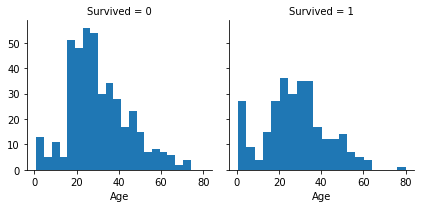

In [12]:
g = sns.FacetGrid(train_df, col='Survived')
g.map(plt.hist, 'Age', bins=20)

### 数値と順序尺度の特徴量の相関

1つのプロットを使用して相関をみるために複数の特徴量を組み合わせることができる。これは、数値とカテゴリカル特徴量を用いて行う。

**観察**

- Pclass=3のほとんどの乗客は生き残れなかった。
- Pclass=2およびPclass3の幼児の乗客はほとんどが生き残った。(仮説2「子供は(年齢<?)は生存していた可能性が高い」を実証した）
- Pclass=1のほとんどの状況は生き残った。(仮説3「上位クラスの乗客(Pclass=1)は生き残った可能性が高い」を実証した）
- Pclassは、乗客の年齢分布によって異なる。

**結論**

- モデルをトレーニングするためにPclassを考慮する。

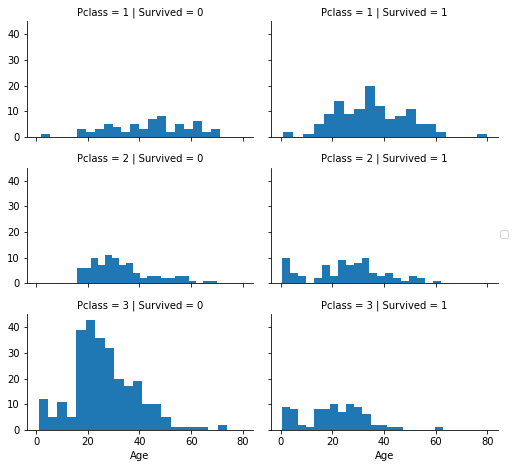

In [13]:
grid = sns.FacetGrid(train_df, col='Survived', row='Pclass', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', bins=20)
grid.add_legend();

### カテゴリカル特徴量の相関

カテゴリカル特徴量と応答変数(Survived)の関係を解析する。これは、数値の値をもつカテゴリカル特徴量と数値特徴量に対して行う。

**観察**

- 女性の乗客は、男性よりもはるかに良好な生存率を示した。(仮説1「女性(性別=女性)は生存していた可能性が高い」を実証した）
- 例外的にEmbarked=Cでは男性の生存率が高い。これは、PclassとEmbarkedとの相関性であり、Pclassの影響が高く、必ずしもEmbarkedとSurvivedの間に直接的な相関関係があるとは言えない。
- Embarked=QでPclass=2と比較した場合、男性はPclass=3でより良い生存率を示した。(Survivedまたは他の重要な特徴量と相関する可能性があるため、Embarkedの欠損値を補完する必要があるかもしれない）
- 乗船港によって、Pclass=3の生存率や男性の生存率が異なる。

**結論**

- モデルの訓練にSex特徴量を追加する。
- モデルの訓練にEmbarked特徴量を補完して追加する。

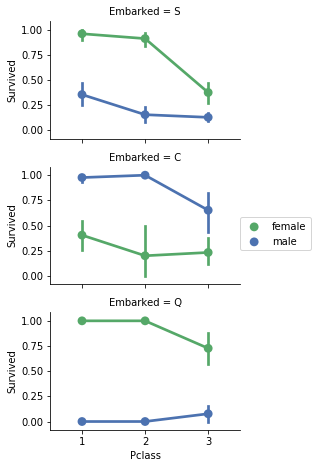

In [14]:
grid = sns.FacetGrid(train_df, row='Embarked', size=2.2, aspect=1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
grid.add_legend()

### カテゴリカル特徴量と数値特徴量の相関

数値以外の値を持つカテゴリカル特徴量と、数値特徴量を関連付けることもできる。今回は、Embarked(カテゴリカルで非数値)、Sex(カテゴリカルで非数値)、運賃(数値で連続値)の間で相関を解析する。

**観察**

- より高い運賃を支払う乗客は、より良い生存率を示した。（仮説「Fareの範囲を特徴量として作成」)
- 乗船港は生存率と相関がある。

**結論**

- Fare特徴量のバンディング(一定の区間で区切ってカテゴリカルにする)を検討する。

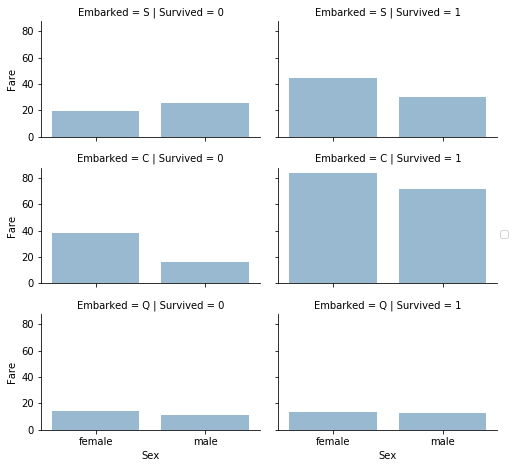

In [15]:
grid = sns.FacetGrid(train_df, row='Embarked', col='Survived', size=2.2, aspect=1.6)
grid.map(sns.barplot, 'Sex', 'Fare', alpha=.5, ci=None)
grid.add_legend()

## データラングリング

これまで、データセットと問題要件に関するいくつかの仮説と結論を集めた。ここまでは、単一の特徴量や値を変更する必要はなかった。これからは、仮説と結論にもとづいて、特徴量の補完/修正/作成を行う。

### 特徴量を削除する

特徴量を削除することで、データポイントの数が減少し、分析をより楽にできる。

仮説と結論に基づいて、TicketとCabinの特徴量を削除する。削除は、訓練データとテストデータの両方で操作を実行し、一貫性を保つ。

In [16]:
print("Before", train_df.shape, test_df.shape, combine[0].shape, combine[1].shape)

train_df = train_df.drop(['Ticket', 'Cabin'], axis=1)
test_df = test_df.drop(['Ticket', 'Cabin'], axis=1)
combine = [train_df, test_df]

"After", train_df.shape, test_df.shape, combine[0].shape, combine[1].shape

Before (891, 12) (418, 11) (891, 12) (418, 11)


('After', (891, 10), (418, 9), (891, 10), (418, 9))

### 既存のものから新しい特徴量を作成する

NameとPassengerIdを削除する前に、NameからTitle(肩書)を取り出し、TitleとSurvivedの相関関係を調べたい。

以下のコードでは、正規表現を使用してTitleを抽出する。正規表現パターン`(\w+\.)`は、Name特徴量内のドット文字で終わる最初の単語と一致する。

**観察**

Title, Age, Survivedをプロットすると、次のような観測結果が得られる。

- ほとんどのTitleは、年齢層を正確に区別する。例：Masterの年齢平均は5歳。
- Title年齢層の生存率はわずかに異なる。
- 一部のTitleはほとんどが生き残った (Mme, Lady, Sir)か、そうでなかった (Don, Rev, Jonkheer)。

**結論**

- モデルトレーニングのために新しいTitle特徴量を保持することに決める。

In [17]:
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract('(\w+)\.', expand=False)
    
pd.crosstab(train_df['Title'], train_df['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


あまり使われないTitleを「Rare」に置き換えたり、より一般的なTitle名に置き換える。

In [18]:
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col', \
        'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

train_df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


カテゴリカルなTitleを序数に変換する。

In [19]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,1


これで、訓練データとテストデータからNameを安全に削除できる。また、生き残ったかどうかという問題とは関係がないため、訓練データのPassengerIdを削除する。

In [20]:
train_df = train_df.drop(['Name', 'PassengerId'], axis=1)
test_df = test_df.drop(['Name'], axis=1)
combine = [train_df, test_df]
train_df.shape, test_df.shape

((891, 9), (418, 9))

### カテゴリカル特徴量の変換

文字列を含む特徴量を数値に変換する。この操作は、ほとんどのモデルアルゴリズムで必要。

Sex特徴量を、女性=1、男性=0という新しい特徴量に変換する。

In [21]:
for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map({'female': 1, 'male': 0}).astype(int)
    
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22.0,1,0,7.2500,S,1
1,1,1,1,38.0,1,0,71.2833,C,3
2,1,3,1,26.0,0,0,7.9250,S,2
3,1,1,1,35.0,1,0,53.1000,S,3
4,0,3,0,35.0,0,0,8.0500,S,1


### 連続的数値の特徴量を補完する

欠損値またはnull値をもつ特徴量を、その欠損値を推定して補完する必要がある。まず、Age特徴量で行う。

数値連続的特徴量を補完するには、3つの方法が考えられる。

1. 簡単な方法として、平均と標準偏差の間の乱数を生成する。

2. 欠損値を推測するより正確な方法は、他の相関する特徴量を使用することである。今回のケースでは、Age、Sex、およびPclassの間の相関を記録する。PclassとSexの特徴量の組み合わせのセット全体でAgeの中央値を使用してAgeの値を推測する。（つまり、Pclass=1/Sex=0、Pclass=1/Sex=1といった組み合わせで、中間のAgeを推測する。）

3. 方法1と2を組み合わせる。中央値に基づいて年齢値を推測する代わりに、PclassとSexの組み合わせのセットに基づいて、平均と標準偏差の愛大になる乱数を使用する。

方法1と3はランダムノイズをモデルに導入することになり、複数回の実行結果が異なる可能性がある。よって方法2を採用する。

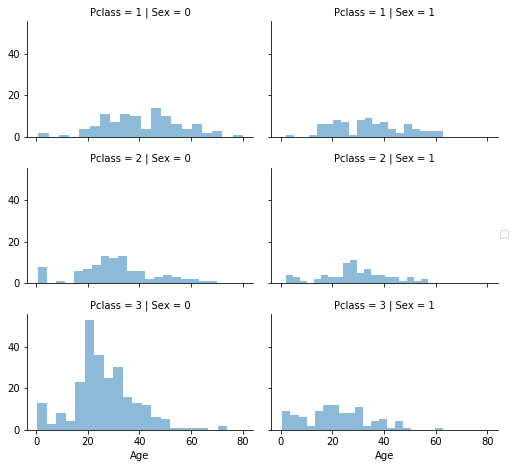

In [22]:
grid = sns.FacetGrid(train_df, row='Pclass', col='Sex', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend()

PclassとSexの組み合わせに基づいて推測されたAge値を格納するため、空の配列を準備する。

In [23]:
guess_ages = np.zeros((2, 3))
guess_ages

array([[0., 0., 0.],
       [0., 0., 0.]])

そして、Sex(0 or 1)とPclass(1, 2, 3)を繰り返し、6つの組み合わせのAgeの推測値を計算する。 

In [24]:
for dataset in combine:
    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = dataset[(dataset['Sex'] == i) & \
                                  (dataset['Pclass'] == j+1)]['Age'].dropna()
            
            # age_mean = guess_df.mean()
            # age_std = guess_df.std()
            # age_guess = rnd.uniform(age_mean - age_std, age_mean + age_std)
            
            age_guess = guess_df.median()
            
            # Convert random age float to nearrest .5 age (TODO: この計算の意図不明)
            guess_ages[i,j] = int( age_guess/0.5 + 0.5) * 0.5
            
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[(dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1),\
                       'Age'] = guess_ages[i,j]
            
    dataset['Age'] = dataset['Age'].astype(int)
    
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22,1,0,7.2500,S,1
1,1,1,1,38,1,0,71.2833,C,3
2,1,3,1,26,0,0,7.9250,S,2
3,1,1,1,35,1,0,53.1000,S,3
4,0,3,0,35,0,0,8.0500,S,1


Ageの区間を作成し、Survivedとの相関を見る。

In [25]:
train_df['AgeBand'] = pd.cut(train_df['Age'], 5)
train_df[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

,AgeBand,Survived
0,"(-0.08, 16.0]",0.550000
1,"(16.0, 32.0]",0.337374
2,"(32.0, 48.0]",0.412037
3,"(48.0, 64.0]",0.434783
4,"(64.0, 80.0]",0.090909


これらの区間に基づいて年齢を序数に置き換える。

In [26]:
for dataset in combine:
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <=32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <=48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <=64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,AgeBand
0,0,3,0,1,1,0,7.2500,S,1,"(16.0, 32.0]"
1,1,1,1,2,1,0,71.2833,C,3,"(32.0, 48.0]"
2,1,3,1,1,0,0,7.9250,S,2,"(16.0, 32.0]"
3,1,1,1,2,1,0,53.1000,S,3,"(32.0, 48.0]"
4,0,3,0,2,0,0,8.0500,S,1,"(32.0, 48.0]"


AgeBand特徴量を削除する。

In [27]:
train_df = train_df.drop(['AgeBand'], axis=1)
combine = [train_df, test_df]
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,1,1,0,7.2500,S,1
1,1,1,1,2,1,0,71.2833,C,3
2,1,3,1,1,0,0,7.9250,S,2
3,1,1,1,2,1,0,53.1000,S,3
4,0,3,0,2,0,0,8.0500,S,1


### 既存の特徴量を組み合わせて新しい特徴量を作成する

ParchとSibSpを組み合わせてFamilySizeとして新しい特徴量を作成する。これにより、データセットからParchとSibSpを削除できる。

In [28]:
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

train_df[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


isAloneというべつの特徴量を作成できる。

In [29]:
for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
    
train_df[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


IsAloneが良さげなので、Parch、SibSp、およびFamilySize特徴量を削除する。

In [30]:
train_df = train_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
test_df = test_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
combine = [train_df, test_df]

train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
0,0,3,0,1,7.2500,S,1,0
1,1,1,1,2,71.2833,C,3,0
2,1,3,1,1,7.9250,S,2,1
3,1,1,1,2,53.1000,S,3,0
4,0,3,0,2,8.0500,S,1,1


PclassとAgeを組み合わせた人工的な特徴量を作成できる。

In [31]:
for dataset in combine:
    dataset['Age*Class'] = dataset.Age * dataset.Pclass
    
train_df.loc[:, ['Age*Class', 'Age', 'Pclass']].head(10)

,Age*Class,Age,Pclass
0,3,1,3
1,2,2,1
2,3,1,3
3,2,2,1
4,6,2,3
5,3,1,3
6,3,3,1
7,0,0,3
8,3,1,3
9,0,0,2


### カテゴリカル特徴量を補完する

Embarked特徴量は、乗船港に基づいてS, Q, Cの値を取る。トレーニングデータ・セットには2つの欠損値があるが、今回は最頻値を設定する。

In [32]:
freq_port = train_df.Embarked.dropna().mode()[0]
freq_port

'S'

In [33]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)
    
train_df[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


### カテゴリカル特徴量を吸う値に変換する

欠損値を補完したので、Embarked特徴量を数値に変換する。

In [34]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2})
    
train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,0,3,0,1,7.2500,0,1,0,3
1,1,1,1,2,71.2833,1,3,0,2
2,1,3,1,1,7.9250,0,2,1,3
3,1,1,1,2,53.1000,0,3,0,2
4,0,3,0,2,8.0500,0,1,1,6


### クリック補完と数値特徴量の変換

この特徴量の最頻値（最も頻繁に搭乗する値）を使用して、テストデータセットの値が不足している場合に、Fare特徴量を補完できる。

> 補完する目的は、欠損値を埋めて、モデルアルゴリズムがある程度望ましい状態で動作すること。必要異常に欠損値の推測に時間をかける必要はない。

通貨を表しているので、運賃の小数点第二位以下を四捨五入する場合もある。

In [35]:
test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)
test_df.head()

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,892,3,0,2,7.8292,2,1,1,6
1,893,3,1,2,7.0000,0,3,0,6
2,894,2,0,3,9.6875,2,1,1,6
3,895,3,0,1,8.6625,0,1,1,3
4,896,3,1,1,12.2875,0,3,0,3


FareBand特徴量を作成することもできる。

In [36]:
train_df['FareBand'] = pd.qcut(train_df['Fare'], 4)
train_df[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)

,FareBand,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


FareBandに基づいてFare特徴量を序数に変換する。

In [37]:
for dataset in combine:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

train_df = train_df.drop(['FareBand'], axis=1)
combine = [train_df, test_df]

train_df.head(10)

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,0,3,0,1,0,0,1,0,3
1,1,1,1,2,3,1,3,0,2
2,1,3,1,1,1,0,2,1,3
3,1,1,1,2,3,0,3,0,2
4,0,3,0,2,1,0,1,1,6
5,0,3,0,1,1,2,1,1,3
6,0,1,0,3,3,0,1,1,3
7,0,3,0,0,2,0,4,0,0
8,1,3,1,1,1,0,3,0,3
9,1,2,1,0,2,1,3,0,0


テストセットは以下の通り。

In [38]:
test_df.head(10)

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,892,3,0,2,0,2,1,1,6
1,893,3,1,2,0,0,3,0,6
2,894,2,0,3,1,2,1,1,6
3,895,3,0,1,1,0,1,1,3
4,896,3,1,1,1,0,3,0,3
5,897,3,0,0,1,0,1,1,0
6,898,3,1,1,0,2,2,1,3
7,899,2,0,1,2,0,1,0,2
8,900,3,1,1,0,1,3,1,3
9,901,3,0,1,2,0,1,0,3


## モデルを作って予測する

以下のアルゴリズムを使う。

- ロジスティック回帰
- k-最近傍法
- サポートベクターマシン
- ナイーブベイズクラス分類器
- 決定木
- ランダムフォレスト
- パーセプトロン


## データを読み込ませる準備

In [51]:
X_train = train_df.drop("Survived", axis=1)
Y_train= train_df["Survived"]
X_test = test_df.drop("PassengerId", axis=1).copy()

X_train.shape, Y_train.shape, X_test.shape

((891, 8), (891,), (418, 8))

まずscikit-learnに読み込ませるために、訓練データとテストデータを用意する。以下のことに注意する。
- X_trainには、応答変数（答えとなる特徴量）を除いた予測変数（応答変数を予測するために使う特徴量のこと）を入れる。
- Y_trainには、応答変数のみを入れる。

X_testには、てテストデータを格納したデータフレームを入れる。X_trainとY_trainのデータを使って訓練したモデルが、訓練データの予測変数から応答変数を予測したときに、どの程度正解できるのかとうことが、このモデルの予測精度の推定になる。

> ここでは、大まかな流れを把握するということで、この予測精度を実際の予測精度の推定値としている。これは、正しいやり方ではない。訓練データを使って学習したモデルで訓練データを使って予測しているので、実際の予測精度よりも良い値が出るためである。一般的には交差検証という手法が用いられるが、ここでは交差検証は行わない。

### ロジスティック回帰

In [52]:
# Logistic Regression

logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log

80.36

ロジスティック回帰を利用して、仮説を検証できる。決定関数内の特徴量の係数を計算することで仮説を検証できる。

正の係数は応答の対象オッズを増加させ（確率を増加させる）、負の係数は応答の対象オッズを減少させる（確率を減少させる）ことを表す。対象オッズの絶対値が大きいほど予測に有用な特徴量だということを表す。

- 性別が最も高い係数で、性能の価値が増加することを意味する。
- 逆にPclassが増加するとSurvived=1の確率が最も低下する。
- `Age*Class`は、Survivedと2番目に高い負の相関関係を持つため、モデル化するのに適した人工的な特徴量と言えそう。
- タイトルが2番目に高い正の相関関係になる。

In [41]:
coeff_df = pd.DataFrame(train_df.columns.delete(0))
coeff_df.columns = ['Feature']
coeff_df["Correlation"]  = pd.Series(logreg.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
1,Sex,2.201527
5,Title,0.398234
2,Age,0.287163
4,Embarked,0.261762
6,IsAlone,0.129140
3,Fare,-0.085150
7,Age*Class,-0.311200
0,Pclass,-0.749007


### サポートベクターマシン

In [42]:
# Support Vector Machines

svc = SVC()
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
acc_svc

83.84

### k-最近傍法

In [43]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
acc_knn

84.74

### ナイーブベイズ分類器

In [44]:
# Gaussian Naive Bayes

gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
acc_gaussian

72.28

### パーセプトロン

In [45]:
# Perceptron

perceptron = Perceptron()
perceptron.fit(X_train, Y_train)
Y_pred = perceptron.predict(X_test)
acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)
acc_perceptron

78.0

### 決定木

In [46]:
# Decision Tree

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree

86.76

### ランダムフォレスト

In [47]:
# Random Forest

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

86.76

## モデルの評価

In [48]:
models = pd.DataFrame({
    'Model': ['SVM', 'KNN', 'Logistic Regression', 'Random Forest', 'Naive Bays', 'Perceptron', 'Decision Tree'],
    'Score': [acc_svc, acc_knn, acc_log, acc_random_forest, acc_gaussian, acc_perceptron, acc_decision_tree]})

models.sort_values(by='Score', ascending=False)

,Model,Score
3,Random Forest,86.76
6,Decision Tree,86.76
1,KNN,84.74
0,SVM,83.84
2,Logistic Regression,80.36
5,Perceptron,78.00
4,Naive Bays,72.28
